In [2]:
#Self-hyperparam selection: https://link.springer.com/article/10.1007/s11063-024-11578-0
#Self-pruning: https://github.com/skarifahmed/seMLP/blob/main/src/Prune.py

In [13]:
from utils import Utils
from color import color 
import pandas as pd
import numpy as np
import os
# libraries
import joblib

# scale features
from sklearn import preprocessing
from sklearn import impute
# classifier
from sklearn.ensemble import ExtraTreesClassifier
# scoring metrics
from sklearn.metrics import confusion_matrix, matthews_corrcoef

# custom scripts
import sys
sys.path.insert(0, "%s" % "CV/")
from sklearn.model_selection import train_test_split, GridSearchCV, GroupShuffleSplit, StratifiedShuffleSplit, cross_validate, StratifiedKFold
from sklearn.metrics import roc_curve, auc, recall_score, accuracy_score, precision_score, confusion_matrix, make_scorer, matthews_corrcoef, jaccard_score

In [4]:
site_path = "/Users/sanjanayasna/csc334/MLP_MAHOMES/data/sites_calculated_features.txt"

In [5]:
#read in feature set:
sites = pd.read_csv(site_path)
sites = sites.set_index('SITE_ID',drop=True)

# The following labels need to be changed after looking over literature (see Feehan, Franklin, Slusky 2021)
change_site_labels = ["5zb8_0", "6aci_0", "6oq7_0", "6pjv_1", "6q55_0",
                      "6q55_2", "6rmg_0", "6rtg_0", "6rw0_0", "6v77_0"]

# The following sites are removed due to unkopwn correct labels (see Feehan, Franklin, Slusky 2021)
sites.loc[sites.index.isin(change_site_labels), 'Catalytic']=True
remove_sites = ["6mf0_1", "6okh_0", "6qwo_0", "6r9n_0"]
sites=sites.loc[~sites.index.isin(remove_sites)]

#print shape of dataset
print(color.BOLD + "Original features:" + color.END)
print("sites: %s \tcolumns: %s"%(sites.shape[0], sites.shape[1]))
sizes = sites.groupby(["Set", "Catalytic"]).size()
print(sizes)
sites.head()

All features:
sites: 3981 	columns: 485
Set   Catalytic
data  False        2636
      True          829
test  False         345
      True          171
dtype: int64


,Catalytic,MetalCodes,MetalAtoms,fa_atr_Sum_3.5,fa_rep_Sum_3.5,fa_sol_Sum_3.5,fa_intra_atr_xover4_Sum_3.5,fa_intra_rep_xover4_Sum_3.5,fa_intra_sol_xover4_Sum_3.5,lk_ball_Sum_3.5,...,geom_cn8,geom_cn9,geom_Filled,geom_PartFilled,geom_AvgN,geom_AvgO,geom_AvgS,geom_AvgOther,SC_vol_perc,Set
SITE_ID,,,,,,,,,,,,,,,,,,,,,
6s9z_0,True,1,1,-33.20757,20.22373,26.34441,-1.88617,0.46054,2.14096,14.05052,...,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.910384,test
6g5l_0,True,1,1,-27.04899,39.17134,22.76555,-1.71942,0.45999,2.05517,12.94894,...,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.862189,test
6hwz_0,True,1,1,-27.30433,35.04867,23.45195,-1.62146,0.35902,1.91231,13.06378,...,0.0,0.0,0.0,1.0,3.0,0.0,0.0,0.0,0.991431,test
6qww_0,True,1,1,-25.36664,12.54178,27.17902,-1.14349,0.22087,1.68091,11.47631,...,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.864546,test
6qww_1,False,1,1,-30.53159,8.99318,27.77842,-1.00782,0.39657,1.04229,13.23736,...,0.0,0.0,1.0,0.0,0.0,4.0,0.0,1.0,0.990893,test


In [16]:
#can change
pkl_out = r'/Users/sanjanayasna/csc334/MLP_MAHOMES/pkl'
save_models = False

#set feature set type
MAHOMES_feature_set = "AllMeanSph"

In [15]:
#Get scaled features
data_scaled, Tsites_scaled = Utils.get_scaled_features(sites =sites, pkl_out=pkl_out, save_models=save_models)

In [17]:
dir = "/Users/sanjanayasna/csc334/MLP_MAHOMES/data/"
#save the scaled data
data_scaled.to_csv(os.path.join(dir, "data_scaled.csv"))
Tsites_scaled.to_csv(os.path.join(dir, "Tsites_scaled.csv"))


#Overview:
# X: training data
# y: target for training data
# testX: test data
# testY: target for test data

X, y = Utils.get_training_data(MAHOMES_feature_set, random_seed = 1, data_scaled= data_scaled)
 ## prepare test-set
testX = Tsites_scaled.copy()
testY = testX['Catalytic']; del testX['Catalytic']
testX = Utils.feature_subset(testX, MAHOMES_feature_set, noBSA=True)

## get multiple predictions for test-set w/ diff random seeds
test_site_preds = {'actual': pd.Series(testY, index=testX.index)}

In [36]:
from KerasMLP import KerasMLP
from KerasLoader import KerasLoader
from sklearn.metrics import mean_squared_error, r2_score
import torch
import matplotlib.pyplot as plt
#initialize dataloader with random sampling of size 10 
dataset = KerasLoader(X, y)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=10, num_workers=0, shuffle = True)
testloader = torch.utils.data.DataLoader(dataset, batch_size=10, num_workers=0, shuffle=True)
init_features = X.shape[1]  

Epoch 1/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8377 - loss: 0.4011
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9134 - loss: 0.2230
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9320 - loss: 0.1679
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9372 - loss: 0.1596
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9694 - loss: 0.0962
Epoch 6/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9749 - loss: 0.0642
Epoch 7/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9794 - loss: 0.0702
Epoch 8/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9807 - loss: 0.0518
Epoch 9/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9904 - loss: 0.0255
Epoch 10/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9876 - loss: 0.0306
Epoch 11/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9868 - loss: 0.0377
Epoch 12/100
104/104 ━━━━━━━━━━━━━━━━━━━━

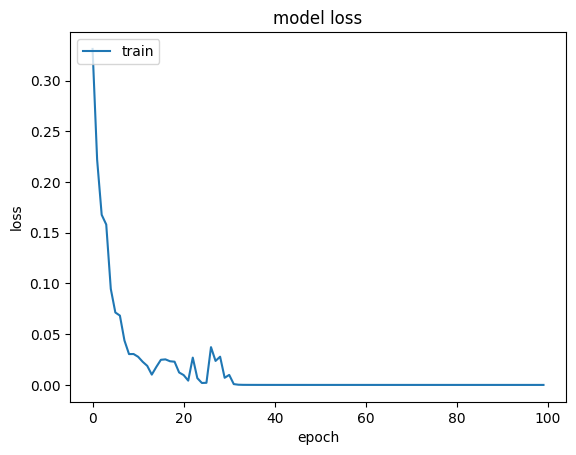

In [38]:
model = KerasMLP.init_model(init_features)
#fit models
loss_history = model.fit(X, y, epochs=100)
#plot losses across epochs
plt.plot(loss_history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()